# Librerias

In [114]:
STUDENTDATAFILE = 'creditos_banco_alumnos.csv'
EVALDATAFILE    = 'creditos_banco_evaluacion.csv'
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
df = pd.read_csv(STUDENTDATAFILE, header=0)

C:\Users\Caste\AppData\Local\Temp\ipykernel_25704\51790742.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


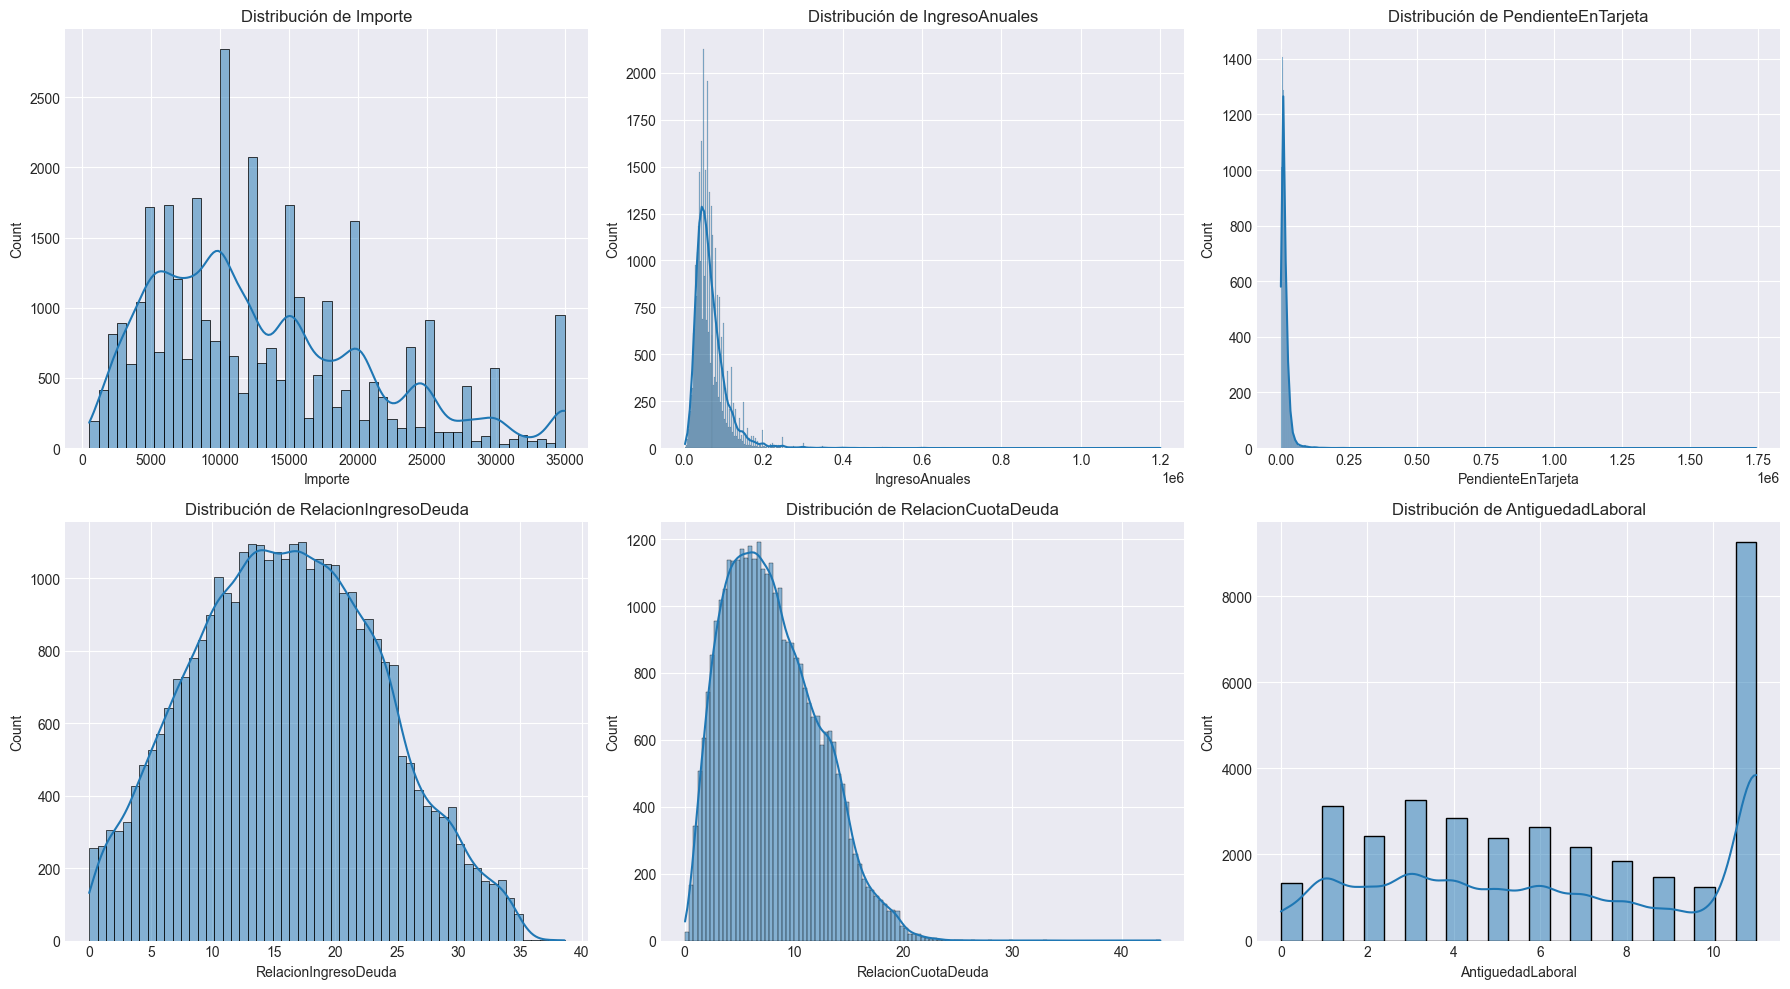

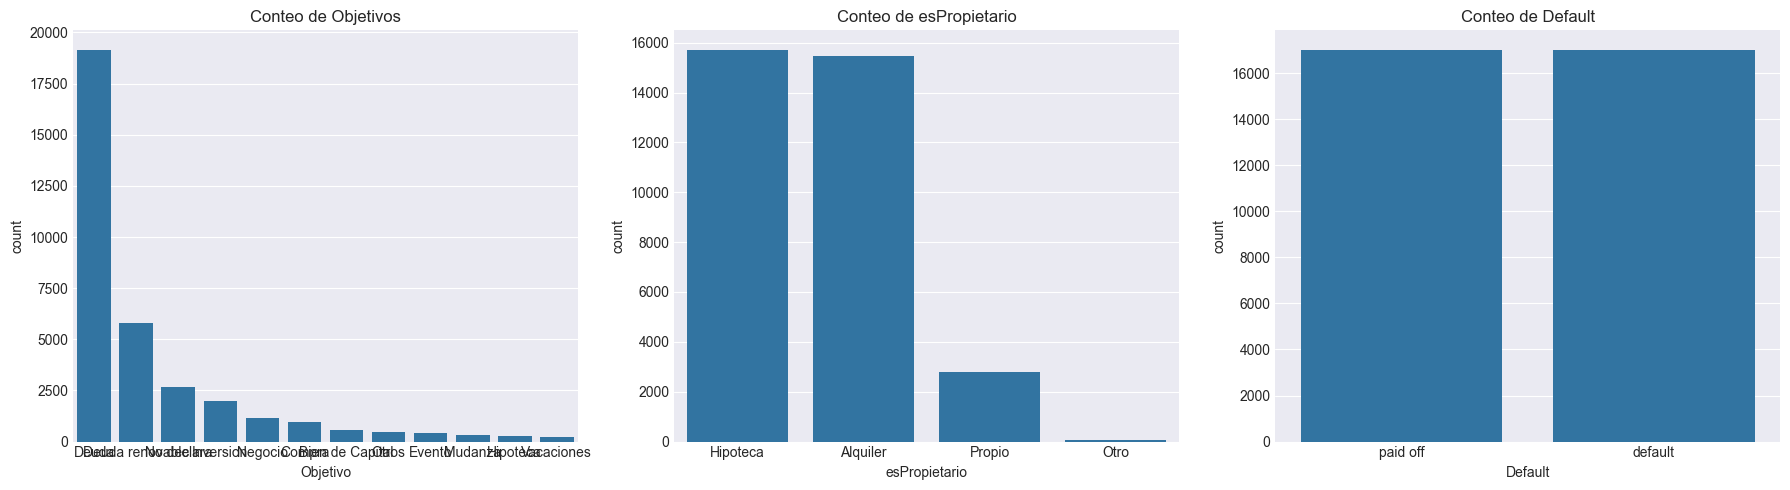

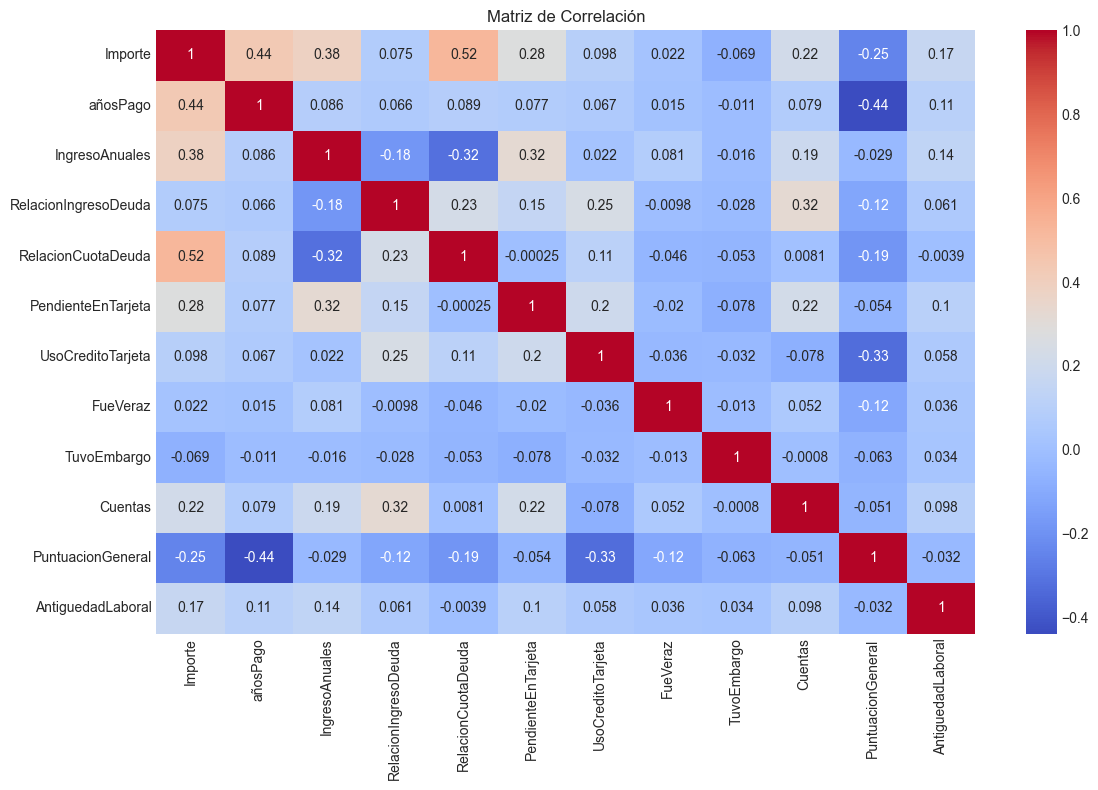

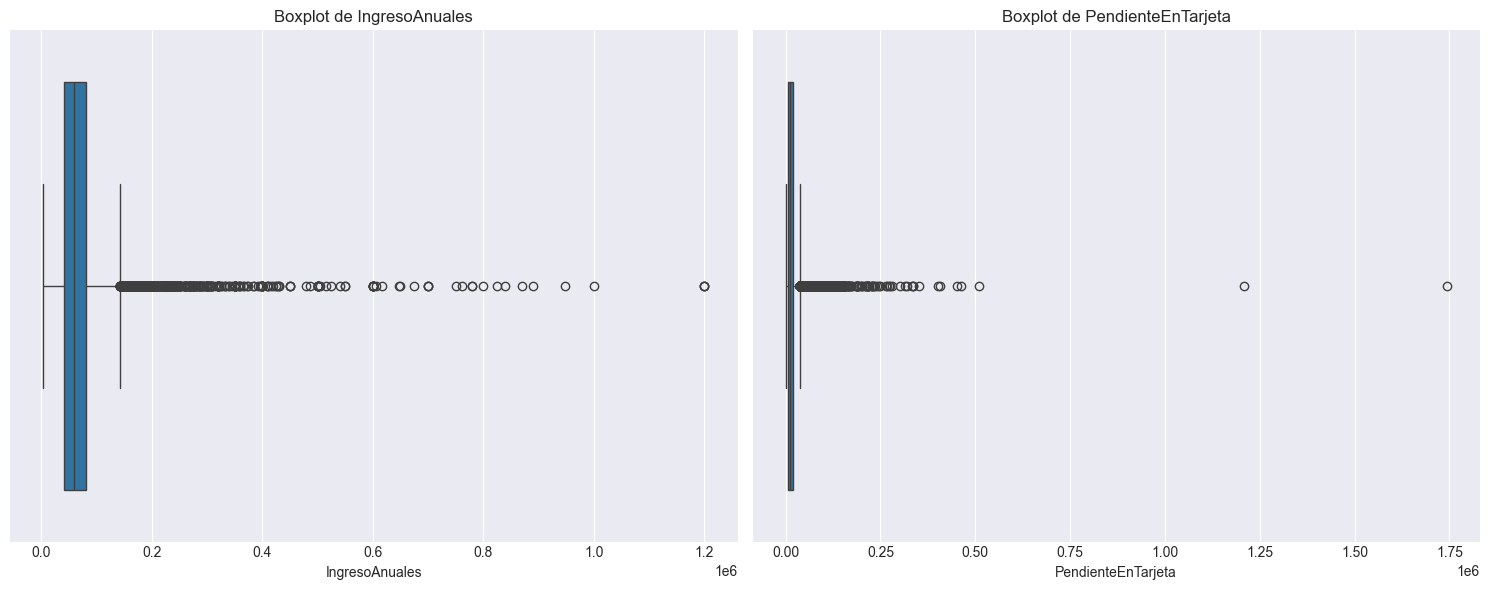

In [116]:
# Configuración general para gráficos
plt.style.use('seaborn-darkgrid')

# 1. Histogramas para la distribución de variables numéricas clave
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.histplot(df['Importe'], kde=True, ax=axes[0, 0]).set_title('Distribución de Importe')
sns.histplot(df['IngresoAnuales'], kde=True, ax=axes[0, 1]).set_title('Distribución de IngresoAnuales')
sns.histplot(df['PendienteEnTarjeta'], kde=True, ax=axes[0, 2]).set_title('Distribución de PendienteEnTarjeta')
sns.histplot(df['RelacionIngresoDeuda'], kde=True, ax=axes[1, 0]).set_title('Distribución de RelacionIngresoDeuda')
sns.histplot(df['RelacionCuotaDeuda'], kde=True, ax=axes[1, 1]).set_title('Distribución de RelacionCuotaDeuda')
sns.histplot(df['AntiguedadLaboral'], kde=True, ax=axes[1, 2]).set_title('Distribución de AntiguedadLaboral')

plt.tight_layout()
plt.show()

# 2. Conteo de valores en las columnas categóricas 'Objetivo', 'esPropietario' y 'Default'
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(data=df, x='Objetivo', order=df['Objetivo'].value_counts().index, ax=axes[0]).set_title('Conteo de Objetivos')
sns.countplot(data=df, x='esPropietario', order=df['esPropietario'].value_counts().index, ax=axes[1]).set_title('Conteo de esPropietario')
sns.countplot(data=df, x='Default', order=df['Default'].value_counts().index, ax=axes[2]).set_title('Conteo de Default')

plt.tight_layout()
plt.show()

# 3. Matriz de correlación para ver relaciones entre variables numéricas
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', ax=ax).set_title('Matriz de Correlación')

plt.tight_layout()
plt.show()

# 4. Boxplots para detectar outliers en 'IngresoAnuales' y 'PendienteEnTarjeta'
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(x=df['IngresoAnuales'], ax=axes[0]).set_title('Boxplot de IngresoAnuales')
sns.boxplot(x=df['PendienteEnTarjeta'], ax=axes[1]).set_title('Boxplot de PendienteEnTarjeta')

plt.tight_layout()
plt.show()


In [117]:
df_limpio = df.dropna()
print(df.shape[0])
print(df_limpio.shape[0])

34006
34006


In [118]:
obj_ordinal = pd.CategoricalDtype(categories=df_limpio.Objetivo.unique(), ordered=True)
df_limpio['Objetivo'] = df_limpio['Objetivo'].astype(obj_ordinal)
df_limpio['Objetivo'] = df_limpio['Objetivo'].cat.codes
esPro_ordinal = pd.CategoricalDtype(categories=df_limpio.esPropietario.unique(), ordered=True)
df_limpio['esPropietario'] = df_limpio['esPropietario'].astype(esPro_ordinal)
df_limpio['esPropietario'] = df_limpio['esPropietario'].cat.codes
df_limpio['Default'] = df_limpio['Default'].map({'paid off': 0, 'default': 1})

In [119]:
print(df_limpio.Objetivo.unique())
print(df_limpio.esPropietario.unique())
df_limpio.head()

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[0 1 2 3]


,Importe,añosPago,IngresoAnuales,RelacionIngresoDeuda,RelacionCuotaDeuda,PendienteEnTarjeta,UsoCreditoTarjeta,Objetivo,esPropietario,FueVeraz,TuvoEmbargo,Cuentas,PuntuacionGeneral,Default,AntiguedadLaboral
0,2000,3,37000,6.29,2.22551,9663,96.6,0,0,0,0,2,4.4,0,2
1,28625,5,64000,15.34,14.07690,20084,60.3,1,0,0,0,18,3.8,0,3
2,10400,3,76000,15.11,5.71753,4808,40.1,0,1,0,1,8,4.4,0,7
3,33425,5,75000,20.85,14.08580,25807,60.7,0,0,0,1,14,4.0,0,11
4,15000,5,55000,7.66,9.43025,8452,49.4,0,1,1,1,10,1.4,1,4


In [120]:
# Seleccionar solo columnas numéricas
numeric_columns = df_limpio.select_dtypes(include=['float64', 'int64']).columns

# Detectar y eliminar outliers usando el método del rango intercuartílico (IQR)
for column in numeric_columns:
    Q1 = df_limpio[column].quantile(0.25)  # Primer cuartil
    Q3 = df_limpio[column].quantile(0.75)  # Tercer cuartil
    IQR = Q3 - Q1  # Rango intercuartílico
    
    # Definir límites inferior y superior
    lower_bound = Q1 - 1.9 * IQR
    upper_bound = Q3 + 1.9 * IQR
    
    # Filtrar registros que están dentro de los límites
    df_limpio = df_limpio[(df_limpio[column] >= lower_bound) & (df_limpio[column] <= upper_bound)]

# Verificar el resultado
print(f"Dataset después de eliminar outliers: {df_limpio.shape}")


Dataset después de eliminar outliers: (24562, 15)


C:\Users\Caste\AppData\Local\Temp\ipykernel_25704\1333084342.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


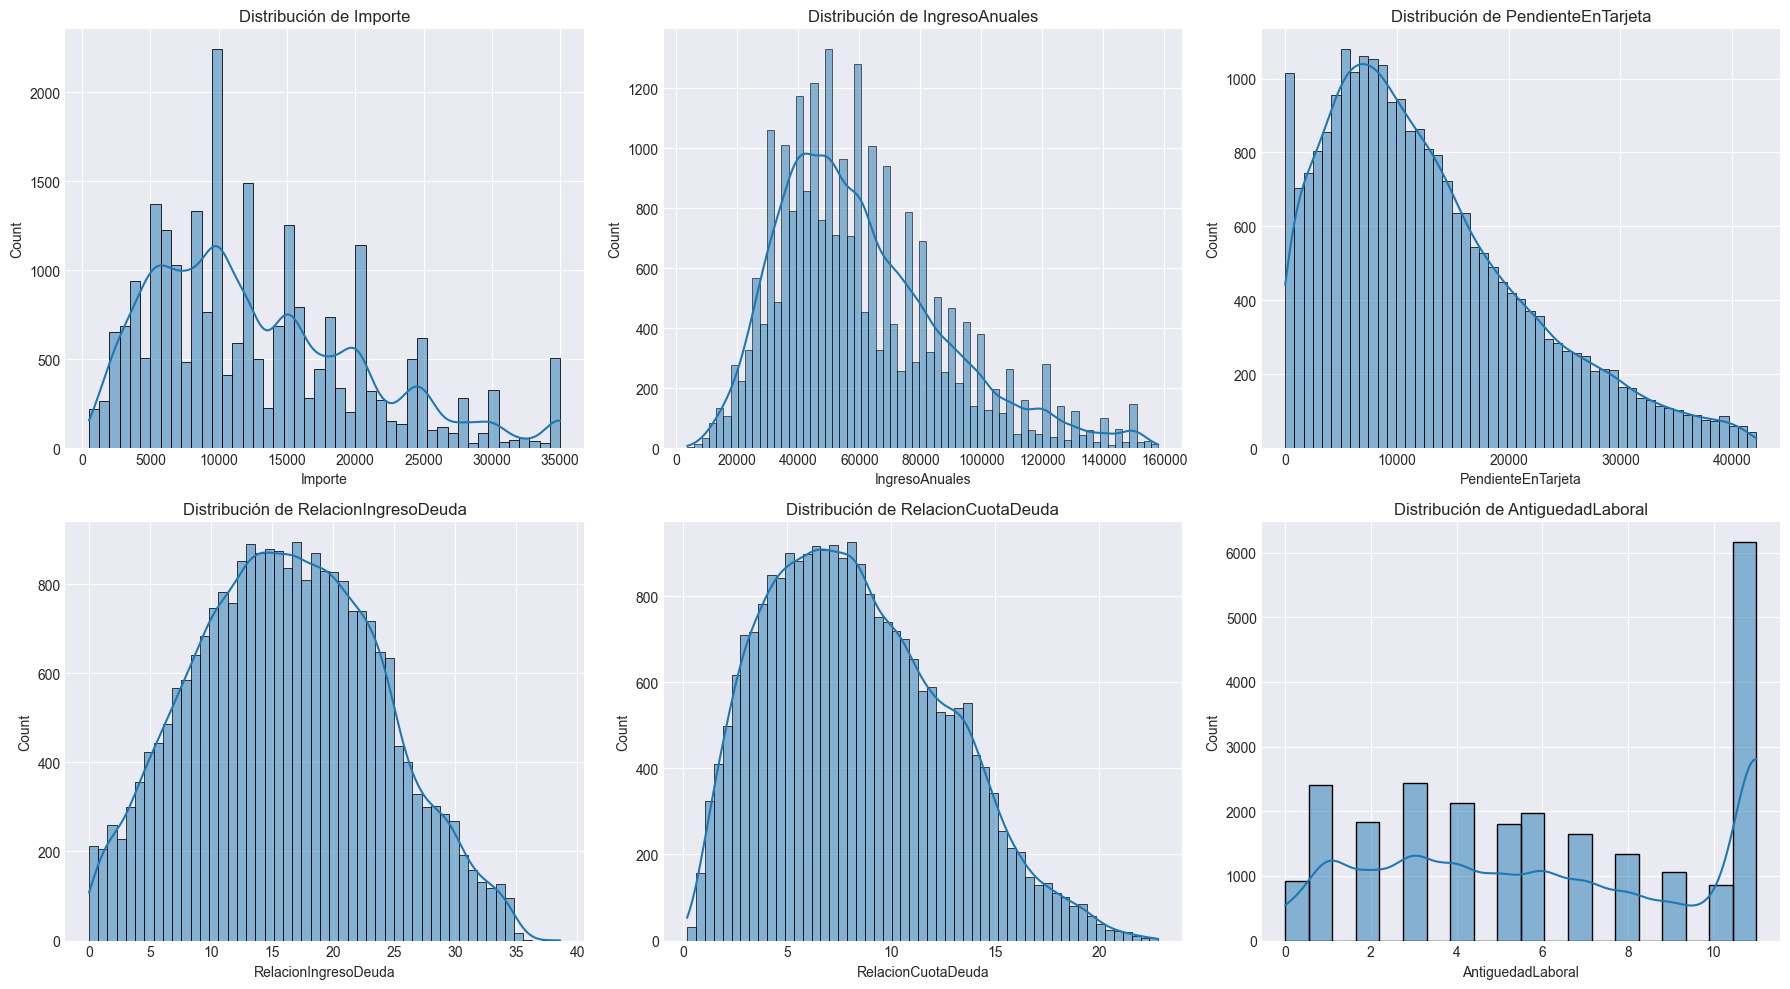

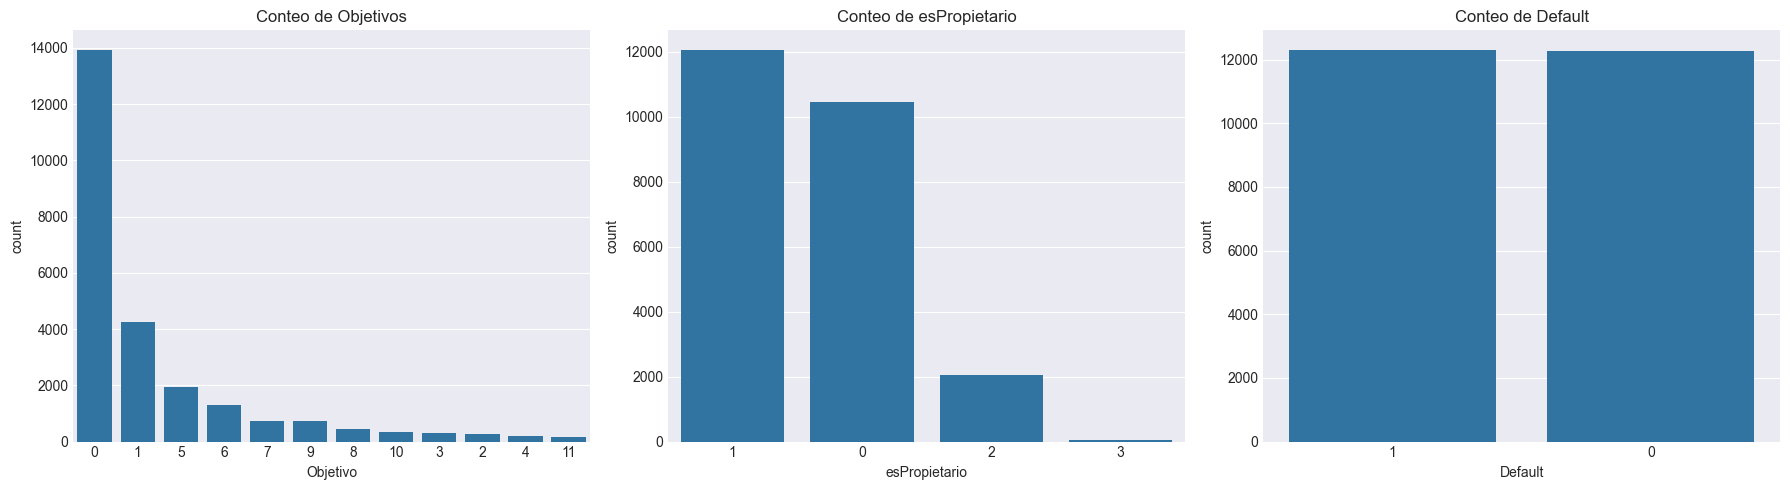

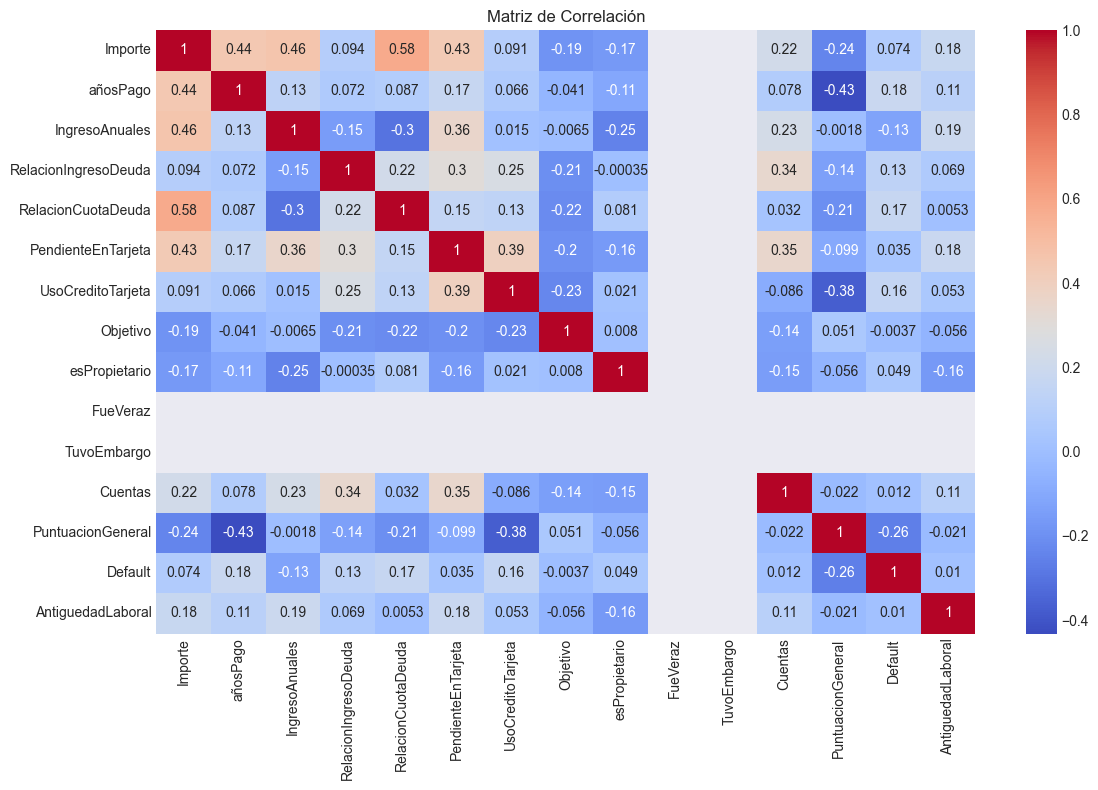

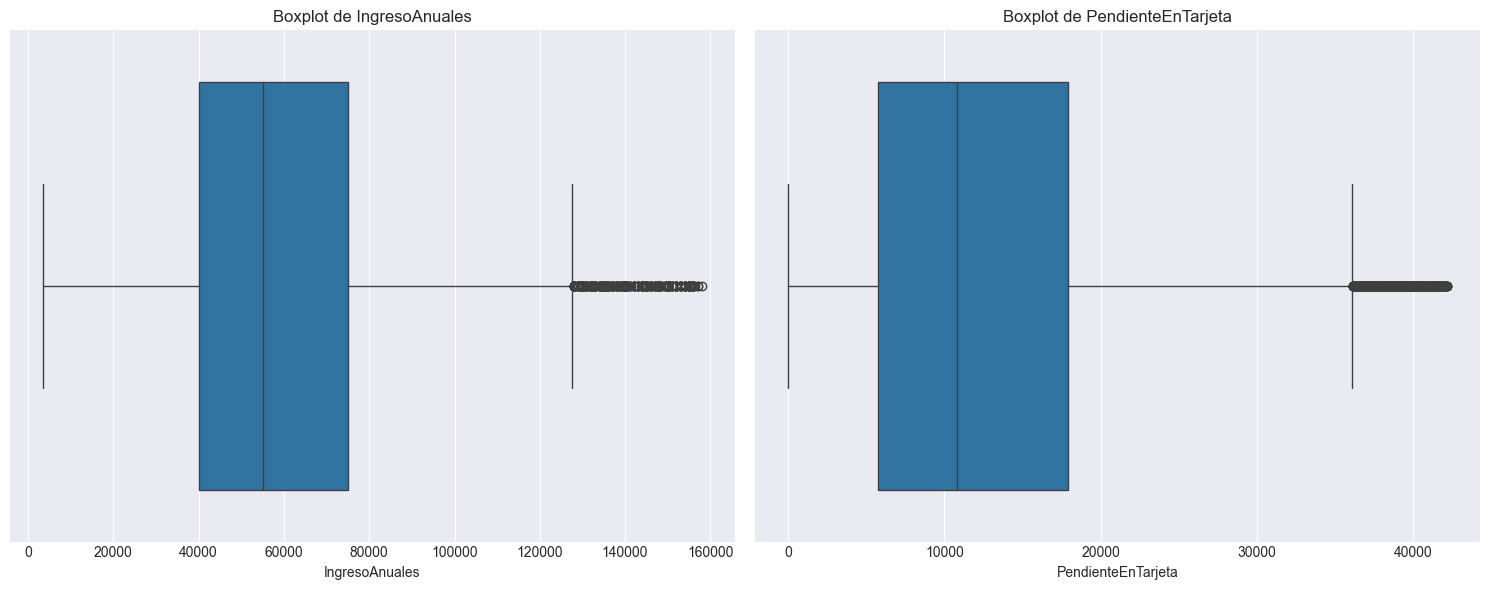

In [121]:
# Configuración general para gráficos
plt.style.use('seaborn-darkgrid')

# 1. Histogramas para la distribución de variables numéricas clave
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.histplot(df_limpio['Importe'], kde=True, ax=axes[0, 0]).set_title('Distribución de Importe')
sns.histplot(df_limpio['IngresoAnuales'], kde=True, ax=axes[0, 1]).set_title('Distribución de IngresoAnuales')
sns.histplot(df_limpio['PendienteEnTarjeta'], kde=True, ax=axes[0, 2]).set_title('Distribución de PendienteEnTarjeta')
sns.histplot(df_limpio['RelacionIngresoDeuda'], kde=True, ax=axes[1, 0]).set_title('Distribución de RelacionIngresoDeuda')
sns.histplot(df_limpio['RelacionCuotaDeuda'], kde=True, ax=axes[1, 1]).set_title('Distribución de RelacionCuotaDeuda')
sns.histplot(df_limpio['AntiguedadLaboral'], kde=True, ax=axes[1, 2]).set_title('Distribución de AntiguedadLaboral')

plt.tight_layout()
plt.show()

# 2. Conteo de valores en las columnas categóricas 'Objetivo', 'esPropietario' y 'Default'
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(data=df_limpio, x='Objetivo', order=df_limpio['Objetivo'].value_counts().index, ax=axes[0]).set_title('Conteo de Objetivos')
sns.countplot(data=df_limpio, x='esPropietario', order=df_limpio['esPropietario'].value_counts().index, ax=axes[1]).set_title('Conteo de esPropietario')
sns.countplot(data=df_limpio, x='Default', order=df_limpio['Default'].value_counts().index, ax=axes[2]).set_title('Conteo de Default')

plt.tight_layout()
plt.show()

# 3. Matriz de correlación para ver relaciones entre variables numéricas
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_limpio.corr(numeric_only=True), annot=True, cmap='coolwarm', ax=ax).set_title('Matriz de Correlación')

plt.tight_layout()
plt.show()

# 4. Boxplots para detectar outliers en 'IngresoAnuales' y 'PendienteEnTarjeta'
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(x=df_limpio['IngresoAnuales'], ax=axes[0]).set_title('Boxplot de IngresoAnuales')
sns.boxplot(x=df_limpio['PendienteEnTarjeta'], ax=axes[1]).set_title('Boxplot de PendienteEnTarjeta')

plt.tight_layout()
plt.show()


In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier



# Separar las variables predictoras y la variable objetivo
X = df_limpio.drop("Default", axis=1)
y = df_limpio["Default"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear y entrenar el clasificador

#best_clf = LogisticRegression()
#best_clf = SVC()    
#best_clf = KNeighborsClassifier(n_neighbors=5)
#best_clf = DecisionTreeClassifier()
#best_clf = RandomForestClassifier(n_estimators=100)
best_clf = GradientBoostingClassifier()
#best_clf = XGBClassifier()
#best_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
#best_clf = RandomForestClassifier(n_estimators=100, random_state=1)
best_clf.fit(X_train, y_train)

# Evaluar el modelo
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.63      0.64      3640
           1       0.65      0.67      0.66      3729

    accuracy                           0.65      7369
   macro avg       0.65      0.65      0.65      7369
weighted avg       0.65      0.65      0.65      7369



In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



# Separar las variables predictoras y la variable objetivo
X = df_limpio.drop("Default", axis=1)

X = X.drop(["RelacionCuotaDeuda", "PendienteEnTarjeta"], axis=1) #eliminas estas columnas ya que tienen una fuerte correlación con otras 

y = df_limpio["Default"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear y entrenar el clasificador

#best_clf = LogisticRegression()
#best_clf = SVC()    
#best_clf = KNeighborsClassifier(n_neighbors=5)
#best_clf = DecisionTreeClassifier()
#best_clf = RandomForestClassifier(n_estimators=100)
#best_clf = GradientBoostingClassifier()
#best_clf = XGBClassifier()
#best_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)


param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestClassifier()

best_clf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)


best_clf = RandomForestClassifier(n_estimators=100, random_state=1)
best_clf.fit(X_train, y_train)

# Evaluar el modelo
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

In [ ]:
#visualizamos los mejores parámetros:
best_clf.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 300}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
#from imblearn.over_sampling import SMOTE

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_limpio.drop("Default", axis=1), df_limpio["Default"], test_size=0.3, random_state=42)

# 2. Aplicar SMOTE para balancear el dataset
#smote = SMOTE(random_state=42)
#X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# 3. Crear un pipeline con el modelo
pipeline = Pipeline([
    ('gb', GradientBoostingClassifier())
])

# 4. Definir los hiperparámetros para el Grid Search
param_grid = {
    'gb__n_estimators': [100, 200],
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [3, 5, 7]
}

# 5. Búsqueda de hiperparámetros
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 6. Evaluar el modelo con el conjunto de prueba
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

### Usando RF con los mejores parametros obtenidos arriba

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 300}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



# Separar las variables predictoras y la variable objetivo
X = df_limpio.drop("Default", axis=1)

X = X.drop(["RelacionCuotaDeuda", "PendienteEnTarjeta", "AntiguedadLaboral"], axis=1) #eliminas estas columnas ya que tienen una fuerte correlación con otras (y antiguedad no tiene correlacion)

y = df_limpio["Default"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear y entrenar el clasificador

dict_weights = {0: 1.2, 1: 1}

best_clf = RandomForestClassifier(bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, class_weight=dict_weights)
best_clf.fit(X_train, y_train)

# Evaluar el modelo
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.79      0.70      2913
           1       0.61      0.42      0.50      2327

    accuracy                           0.62      5240
   macro avg       0.62      0.60      0.60      5240
weighted avg       0.62      0.62      0.61      5240



### USANDO SVC Y ESTANDARIZANDO LAS VARIABLES

In [ ]:
# normalizamos las variables:

from sklearn.preprocessing import StandardScaler

# escalamos las columnas numéricas

numeric_columns2 = numeric_columns
#print(numeric_columns2)

numeric_columns2 = numeric_columns2.drop(['Default', "RelacionCuotaDeuda", "PendienteEnTarjeta", "AntiguedadLaboral"])


features = df_limpio[numeric_columns2]

ct = ColumnTransformer([
    ('scaler', StandardScaler(), numeric_columns2)
])

features.head()

df_limpio[numeric_columns2] = ct.fit_transform(features)

In [ ]:
print(numeric_columns2)


Index(['Importe', 'añosPago', 'IngresoAnuales', 'RelacionIngresoDeuda',
       'UsoCreditoTarjeta', 'FueVeraz', 'TuvoEmbargo', 'Cuentas',
       'PuntuacionGeneral'],
      dtype='object')


In [ ]:
df_limpio.head()

,Importe,añosPago,IngresoAnuales,RelacionIngresoDeuda,RelacionCuotaDeuda,PendienteEnTarjeta,UsoCreditoTarjeta,Objetivo,esPropietario,FueVeraz,TuvoEmbargo,Cuentas,PuntuacionGeneral,Default,AntiguedadLaboral
0,-1.386645,-0.569859,-0.849694,-1.308573,2.22551,9663,1.572860,0,0,0.0,0.0,-1.853828,-0.212526,0,2
1,2.031443,1.754819,0.125744,-0.116070,14.07690,20084,0.149016,1,0,0.0,0.0,1.851660,-0.621709,0,3
5,0.924175,-0.569859,2.871423,-0.795994,5.36409,21422,-0.753144,1,1,0.0,0.0,-1.159049,1.424203,0,5
7,1.566070,-0.569859,0.866355,-0.461303,12.79430,24153,1.102168,1,1,0.0,0.0,-0.464270,-1.030891,0,8
8,0.506944,1.754819,-0.838856,-0.170095,15.02770,13843,0.525570,0,0,0.0,0.0,-0.001084,-1.167285,1,11


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC



# Separar las variables predictoras y la variable objetivo
X = df_limpio.drop("Default", axis=1)
X = X.drop(["RelacionCuotaDeuda", "PendienteEnTarjeta", "AntiguedadLaboral"], axis=1) #eliminas estas columnas ya que tienen una fuerte correlación con otras 

y = df_limpio["Default"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear y entrenar el clasificador

parameter_space = {'kernel': ('rbf', 'poly'), 'gamma': ('auto', 'scale')}

clf = SVC(gamma='auto')

best_clf = GridSearchCV(clf, parameter_space, cv=5, refit=True, n_jobs=-1)
best_clf.fit(X_train, y_train)

# Evaluar el modelo
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.63      0.64      3640
           1       0.65      0.66      0.66      3729

    accuracy                           0.65      7369
   macro avg       0.65      0.65      0.65      7369
weighted avg       0.65      0.65      0.65      7369



In [ ]:
best_clf.best_estimator_

SVC(gamma='auto')

### Usando redes neuronales

In [ ]:
from sklearn.neural_network import MLPClassifier


# Separar las variables predictoras y la variable objetivo
X = df_limpio.drop("Default", axis=1)
X = X.drop(["RelacionCuotaDeuda", "PendienteEnTarjeta", "AntiguedadLaboral"], axis=1) #eliminas estas columnas ya que tienen una fuerte correlación con otras 

y = df_limpio["Default"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear y entrenar el clasificador

best_clf = MLPClassifier(solver='adam', hidden_layer_sizes=(20,20), random_state=1, max_iter=500)
best_clf.fit(X_train, y_train)

# Evaluar el modelo
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.56      0.59      3640
           1       0.61      0.67      0.64      3729

    accuracy                           0.62      7369
   macro avg       0.62      0.61      0.61      7369
weighted avg       0.62      0.62      0.61      7369

